# Exploring decision trees

The purpose of this notebook is to explore the innards of decision trees (collections of which are used in random forests) by varying parameters.  In particular, we will investigate the difference between setting `max_depth` versus `min_samples_leaf` for our dataset.  

From the pure time-series representing the dataset, we will generate a dataset where the `timestamp` is replaced with two categorical features:  
- `Weekofday`;  
- `Minuteofday`.  

See notebook `la-permanence-feature-importance.ipynb` for a rationale on this choice.


Also, for simplicity, we will focus on the data from the rue du Fer à Moulin location.

The observations are drawn based on particular runs and will be recorded if they seem to be persistent.  Since there is element of randomness, it is possible that particular runs will not be entirely consistent with the observations, but hopefully this should be the case only very occasionally.


## Reference
A lot of this notebook follows fastai's [Introduction to Machine Learning for Coders](http://course18.fast.ai/ml).  Link to the [course repository](https://github.com/fastai/fastai/tree/master/courses/ml1).

Useful info from this [stackexchange post](https://datascience.stackexchange.com/questions/19842/anyway-to-know-all-details-of-trees-grown-using-randomforestclassifier-in-scikit), in particular, [an example](https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html) from `scikit-learn`'s documentation.

# Helpful remarks on decision trees

The class `DecisionTreeRegressor` is a class of **binary** decision trees.  At each node, the algorithm will split into two further nodes unless:
- either it has reached a maximum depth as prescribed in the parameter `max_depth`;  
- or it would produce a node with less than a mininum number of samples, as prescribed in the parameter `min_samples_leaf`;  
- or the algorithm decides that the information gain by splitting the node further is insufficient.  

Assuming no limitation on `max_depth` and `min_samples_leaf`, a **balanced tree** is one where the process has stopped where all leaves contain a single sample, noting that the leaves need not be of equal sizes.  A bit more generally, if `max_depth` is prescribed, the process stops when all nodes have reached a depth of `max_depth`.  In this case, the **capacity** of the tree, that is, the total number of nodes, is `2**(max_depth + 1)` (the maximum possible), and it contains `2**max_depth` leaves (the maximum possible) all with depth equal to `max_depth`.  

In fact, the following relationship holds in general for any binary tree, whether it is balanced or not:

$$\textrm{capacity} = 2\,\times\,\textrm{number of leaves} - 1$$

The argument is simple: starting from a balanced tree, every time two leaves are collapsed into one, the total number of nodes decreases by two but the total number of leaves decreases only by (the two leaves have been replaced with one leave, previously a node which was not a leaf).  

## Imports, constants, and functions

In [1]:
# =======
# IMPORTS
# =======

import os
import sys
import re
# import tqdm  # class tqdm.tqdm imported from fastai.structured - see below

import pytz
import datetime

import math
import numpy as np
import pandas as pd
# from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

sys.path.append(os.path.join(os.path.expanduser("~"), "Computing/fastai/old"))
from fastai.structured import *

import matplotlib.pyplot as plt
# import seaborn as sns

%matplotlib inline

# =========
# CONSTANTS
# =========

    # Timezones
tz_utc = pytz.timezone("UTC")  # timestamp is in UTC standard
tz_paris = pytz.timezone("Europe/Paris")  # locations are in Paris, France

# Resampling rule: resolution of time regularization
RESOL = 2  # 10
RULE = f"{RESOL}T"
TWO_WEEKS = 2*7*24*(60 // RESOL)  # validation period is two weeks

# PLOTTING PARAMETERS
FIGSIZE = (16, 6)
ALPHA = 0.7

# Colors
# COL_MOULIN = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
# COL_ALESIA = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
COL_TRAIN = plt.rcParams['axes.prop_cycle'].by_key()['color'][2]
COL_VALID = plt.rcParams['axes.prop_cycle'].by_key()['color'][3]
COL_PREDICT = plt.rcParams['axes.prop_cycle'].by_key()['color'][4]

# =========
# FUNCTIONS
# =========

def split_vals(df, n):
    return df[:n].copy(), df[n:].copy()
        
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def dectree_depths(tree):
    """Return a dataframe giving depth of tree nodes and whether they are leaves"""
    n_nodes = tree.node_count
    children_left = tree.children_left
    children_right = tree.children_right
    feature = tree.feature
    threshold = tree.threshold
    
    node_depths = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leafs = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depths[node_id] = parent_depth + 1
    
        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leafs[node_id] = True
    depths = pd.DataFrame(index=range(n_nodes), data=np.stack([node_depths, is_leafs]).T, columns=['depth', 'is_leaf'])
    depths['is_leaf'] = depths['is_leaf'].astype(bool)
    depths.index.name = 'leaf id'
    return depths

## Load and preprocess data

The dataset consists of pure time-series:
-  `timestamp` gives the date and time (UTC) of data collection in the format "YYYY-MM-DD-hh-mm-ss" where
  - `YYYY=year`,
  - `MM=month`,
  - `DD=day`,
  - `hh=hour`,
  - `mm=minute`,
  - `ss=second`;  
-  `Moulin` gives the number of available seats at the rue du Fer à Moulin location (maximum is 63);
-  `Alésia` gives the number of available seats at the rue d'Alésia location (maximum is 82).  

If we are to use random forests, or decision trees, on the data, we need to convert the `timestamp` into a set of categorical features.  We will use:
- `Minuteofday`: this will capture the 24-hour seasonality in the data;  
- `Dayofweek`: this will capture the 7-day seasonality in the data.  

**Note**: the name of the dataset, `attendance.csv`, is a misnomer, as the file actually records the number of *available* seats, rather than the number of seats used.  

In [2]:
# %%prun
%time

# =========
# METADATA ON THE DATA
# =========

filename = 'attendance.csv'
foldername = 'Projects/la_permanence'
filepath = os.path.join(os.path.expanduser("~"), foldername, filename)
filesize = os.path.getsize(filepath)

COL_WIDTH = 20

if filesize > 1e6:
    print("{0}{1:d}MB".format("File size:".ljust(COL_WIDTH), filesize//int(1e6)))
elif filesize > 1e3:
    print("{0}{1:d}KB".format("File size:".ljust(COL_WIDTH), filesize//int(1e3)))
else:
    print("{0}{1:d}B".format("File size:".ljust(COL_WIDTH), filesize))

line_number = !wc -l < {filepath}
line_number = int(line_number[0])
print("{0}{1}".format("Number of rows:".ljust(COL_WIDTH), line_number))
first_row = !head -1 {filepath}
column_names = first_row[0].split(',')
print("{0}{1}".format("Names of columns:".ljust(COL_WIDTH), ", ".join(column_names)))


dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d-%H-%M-%S')

# =========
# LOAD DATA
# =========

print("Load data...")
raw_data = pd.read_csv(
    filepath,
    sep=',',
    dtype={'Moulin': np.uint8, 'Alésia': np.uint8},
    parse_dates=['timestamp'],
    date_parser=dateparse
)

# ========================
# ADJUSTING FOR TIMEZONES
# The `timestamp` values are in the UTC standard, while the coworking spaces are located in Paris, France:
# ========================

print("Adjust for timezones...")
raw_data['timestamp'] = raw_data['timestamp'].apply(lambda ts: ts.tz_localize(tz_utc).tz_convert(tz_paris))

# ===================
# TIME REGULARIZATION
# The data is collected at irregular times and thus we resample (at a resolution specified in `RULE`) and interpolate to regularize the data:
# ===================

print("Perform time regularization...")
raw_data.set_index("timestamp", inplace=True)
raw_data = raw_data.resample(RULE).mean().interpolate().round().astype(np.uint8)
raw_data.reset_index('timestamp', inplace=True)

# ==========================
# EXPAND DATE INFORMATION
# Create new features from `timestamp` to pass to decision tree
# ==========================

print("Expand date information...")
timestamps = raw_data.loc[:, ['timestamp']]
# attributes = ['Week', 'Dayofweek', 'Hour', 'Minute']
attributes = ['Dayofweek', 'Hour', 'Minute']
for attr in attributes:
    raw_data[attr] = getattr(raw_data['timestamp'].dt, attr.lower())
raw_data['Minuteofday'] = 60*raw_data['Hour'] + raw_data['Minute']
raw_data.drop(['timestamp', 'Hour', 'Minute'], axis=1, inplace=True)

print("New columns: {0}".format(", ".join(raw_data.columns)))
# ===============
# TYPE CONVERSION
# ===============

print("Type conversion...")
# raw_data['Week'] = raw_data['Week'].astype(np.uint8)
raw_data['Dayofweek'] = raw_data['Dayofweek'].astype(np.uint8)
raw_data['Minuteofday'] = raw_data['Minuteofday'].astype(np.uint16)

# ===============================================
# Separating dependent from independent variables
# Also: extract data from location in rue du Fer à Moulin
# ===============================================
print("Separate dependent from independent variables...")
df_trn, y_trn, nas = proc_df(raw_data.drop('Alésia', axis=1), 'Moulin')

# =======================================
# Split into training and validation sets
# =======================================

print("Split into training and validation sets...")
n_valid = TWO_WEEKS  
n_trn = raw_data.shape[0] - n_valid

X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(raw_data, n_trn)

# For plotting purposes:
timestamps_train = timestamps.iloc[0:n_trn].copy()
timestamps_valid = timestamps.iloc[n_trn:].copy()

print("Done.")

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.96 µs
File size:          1MB
Number of rows:     49476
Names of columns:   timestamp, Moulin, Alésia
Load data...
Adjust for timezones...
Perform time regularization...
Expand date information...
New columns: Moulin, Alésia, Dayofweek, Minuteofday
Type conversion...
Separate dependent from independent variables...
Split into training and validation sets...
Done.


# Structure of decision trees with `max_depth` prescribed

We begin with examining the structure of decision trees when `max_depth` is prescribed and the effect of varying it.  Specifically, we will use two values:
- `max_depth=5`,  
- `max_depth=10`.  

From experience, these two values seem to represent two different regimes of the decision trees and there is a threshold around `max_depth = 8`.  

By prescribing `max_depth`, we expect that trees will generally have this value for their maximum depth.  However, it is possible that the algorithm stops before reaching a depth of `max_depth`.  

Note that, given the size of the dataset, namely

In [3]:
raw_data.shape[0]

60487

there is no point in assigning a value to `max_depth` greater than

In [4]:
math.ceil(np.log2(raw_data.shape[0]))

16

## Create and train decision trees

In [5]:
%time

n_estimators = 200  # 100  # 400 # 
max_depth = 10 # 5 # 10
max_features = 2 # dataframes has only two features

rf = RandomForestRegressor(
    n_jobs=-1,
    n_estimators=n_estimators,
    max_depth=max_depth,
    max_features=max_features
);
rf.fit(X_train, y_train)
estimators = rf.estimators_

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.96 µs


## Global structure properties

We first look at the **maximum depth**,  **number of leaves**,  and **capacity** in the trees of our list:

In [6]:
tree_info = pd.DataFrame(
    data=[(estimator.tree_.max_depth, dectree_depths(estimator.tree_)['is_leaf'].sum(), estimator.tree_.capacity)
          for estimator in estimators],
    columns=['max depth', 'nb of leaves', 'capacity']
)
tree_info.index.name = 'trial nb'

# tree_info.describe()

## Number of leaves

The maximum number of leaves for a binary tree of maximum depth equal to `max_depth` equals

In [7]:
2**max_depth

1024

For the estimators in our list, we find:

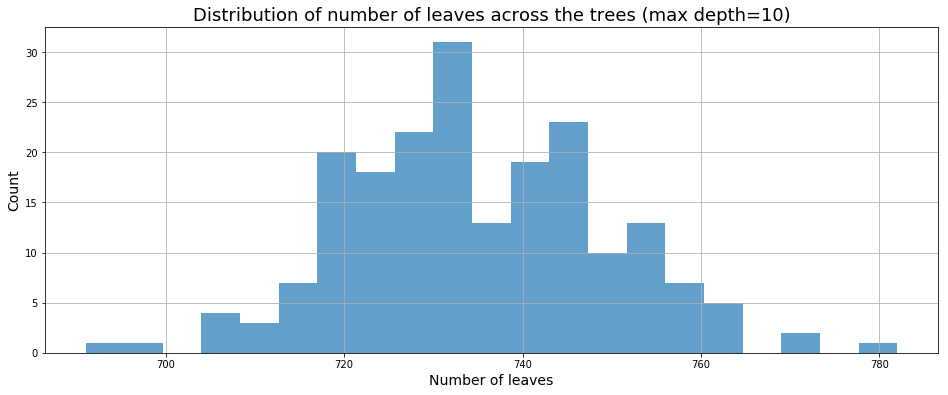

In [8]:
fig, ax = plt.subplots(figsize=FIGSIZE);

bins = 21
tree_info['nb of leaves'].hist(bins=bins, alpha=0.7, ax=ax);
ax.set_title("Distribution of number of leaves across the trees (max depth={0})".format(max_depth), fontsize=18);
ax.set_xlabel("Number of leaves", fontsize=14);
ax.set_ylabel("Count", fontsize=14);

For `max_depth = 5`, all trees in our list have reached their maximum capacity.

For `max_depth = 10`, **every** tree:  
- has a number of leaves strictly less than the maximum possible;
- has strictly more than half that the maximum number of leaves.  

Recalling the binary structure of the trees, this implies that:  
- every tree has at least one path of depth equal to `max_depth`;
- every tree has at least one path of depth strictly less than `max_depth`.  

In conclusion, whether `max_depth = 5` or `10`, 
- every tree has a maximum depth of `max_depth`; and  
- the number of leaves is relatively uniform across trees.  

Next we verify this directly by inspecting the depths in the trees.

## Maximum depth
Let's inspect the maximum depths of the trees:

In [9]:
list(tree_info['max depth'].unique())

[10]

As we already knew, a maximum depth of `max_depth` is attained in all trees.


## Depth of leaves

To refine our understanding of the structure of the trees, we calculate the depths of all leaves and all trees:

In [10]:
depths = pd.concat(
    [dectree_depths(estimator.tree_).assign(**{'trial': i})  for i, estimator in enumerate(estimators)],
    axis=0
).query('is_leaf == True').drop('is_leaf', axis=1)
# depths.info()

In [11]:
depth_distribution = depths['depth'].value_counts().to_frame().rename(columns={'depth': 'count'})
# depth_distribution

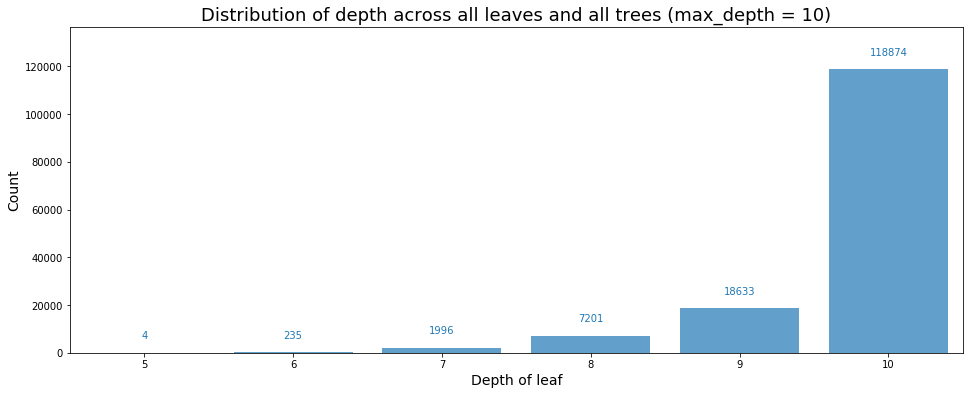

In [12]:
fig, ax = plt.subplots(figsize=FIGSIZE)

ax.bar(x=depth_distribution.index, height=depth_distribution['count'], alpha=ALPHA);

ax.set_title("Distribution of depth across all leaves and all trees (max_depth = {0})".format(max_depth), fontsize=18)
ax.set_xlabel("Depth of leaf", fontsize=14);
ax.set_ylabel("Count", fontsize=14);

dy = depth_distribution['count'].max()/20


for index, row in depth_distribution.iterrows():
    ax.text(index, row[0] + dy, int(row[0]), horizontalalignment='center', color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
# for i, v in list(zip(bins, n)):
#     ax.text(i + 0.5, v + dv, int(v), horizontalalignment='center', color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0])

ax.set_ylim([0, depth_distribution['count'].max() + 3*dy]);
ax.set_xlim([depth_distribution.index.min() - 0.5, depth_distribution.index.max() + 0.5]);
# ax.set_xticks(range(depth_distribution['count'].min(), depth_distribution['count'].max() + 1))



With `max_depth = 5`, the algorithm has reached a depth of `max_depth` for all leaves among all trees.  

With `max_depth = 10`, the algorithm has reached a depth of `max_depth` for most leaves (among all leaves from all trees).  

### Total depth

The distribution above lumped together the leaves of all trees, since for a large number of trees it is difficult to visualize the distribution of distributions.  
One way to summarize the distribution of depths in a tree is to calculate its **total (leaf) depth**, that is, the sum of the depths over all its leaves.  We are of course losing information, since we reduce the entire depth distribution in a tree to a single number (**to do**: *the structure of a binary tree imposes rather strong restriction, investigate whether the distribution of depth in a binary tree can actually be uniquely determined by a single quantity*).  

Note that for a balanced tree, the total leaf depth is

In [13]:
max_depth * 2**max_depth

10240

In [14]:
total_depths = depths.groupby('trial').sum().rename(columns={'depth': 'total depth'})

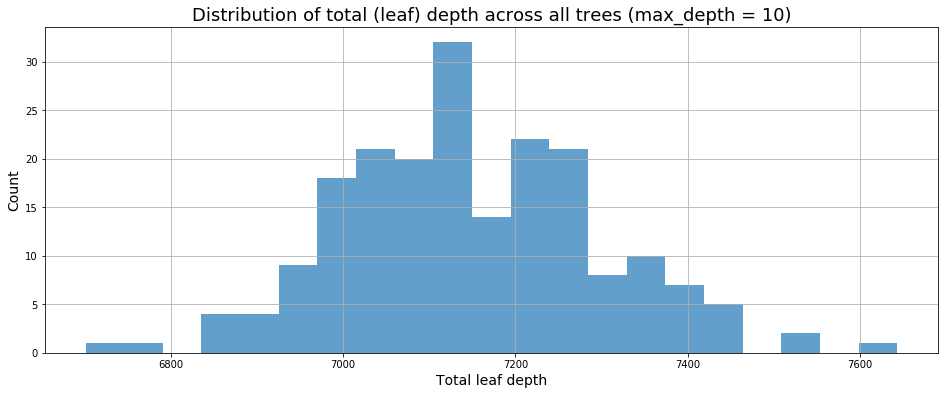

In [15]:
fig, ax = plt.subplots(figsize=FIGSIZE)

bins = 21

total_depths.hist(bins=bins, alpha=ALPHA, ax=ax);
ax.set_title("Distribution of total (leaf) depth across all trees (max_depth = {0})".format(max_depth), fontsize=18);
ax.set_xlabel("Total leaf depth", fontsize=14);
ax.set_ylabel("Count", fontsize=14);

Again because we can calculate the total leaf depth of a balanced tree, with this single plot, we see at once that:  
- with `max_depth = 5`, all leaves in every tree have a depth of `max_depth`;  
- with `max_depth = 10`, every tree contains at least one leaf with depth strictly less than `max_depth`.  

Our considerations thus far have not addressed the size of the leaves, that is, the number of (training) samples that they contain.  To do this we first look at how the algorithm assings samples to leaves.  

## Assigning samples to leaves
Record how the training samples are grouped in the leaves, for each estimator:

In [16]:
samples_to_leaves = [pd.DataFrame(data=estimator.apply(X_train), columns=['leaf id']).assign(**{'trial': i}) for i, estimator in enumerate(estimators)]
samples_to_leaves = pd.concat(samples_to_leaves, axis=0)
samples_to_leaves.index.name = 'sample id'
samples_to_leaves.reset_index(inplace=True)
samples_to_leaves = samples_to_leaves[['trial', 'sample id', 'leaf id']]
samples_to_leaves.sample(5)

,trial,sample id,leaf id
1637754,32,24730,68
7543636,149,32993,799
7828709,155,15624,324
6524948,129,22445,886
6665448,132,11724,1181


## Size of leaves

The **size of a leaf** in a tree is the number of training samples it contains.  For each tree we order the leaves in decreasing size and record them in the dataframe `leaf_sizes`:

In [17]:
leaf_sizes = samples_to_leaves.groupby(['trial', 'leaf id'])['sample id'].count().reset_index().rename(index=str, columns={'sample id': 'leaf size'})
leaf_sizes = leaf_sizes.groupby('trial', group_keys=False).apply(lambda x: x.sort_values('leaf size', ascending=False))
leaf_sizes.drop('leaf id', axis=1, inplace=True)
leaf_sizes = leaf_sizes.groupby('trial').apply(lambda x: x.reset_index(drop=True))[['leaf size']].reset_index().rename(index=str, columns={'level_1': 'rank'})

leaf_sizes_pivot = pd.pivot_table(leaf_sizes, index='rank', columns='trial', values='leaf size')

leaf_sizes.head()

,trial,rank,leaf size
0,0,0,2120
1,0,1,1750
2,0,2,1330
3,0,3,1134
4,0,4,1020


In [18]:
leaf_sizes[['leaf size']].describe()

,leaf size
count,146943.000000
mean,68.607555
std,166.876554
min,10.000000
25%,10.000000
50%,20.000000
75%,60.000000
max,2820.000000


We see that the size of the leaves, taken collectively across all trees, can vary greatly.  

The following plot gives an idea of how regularly, and fast, the leaf size decreases in a typical tree:

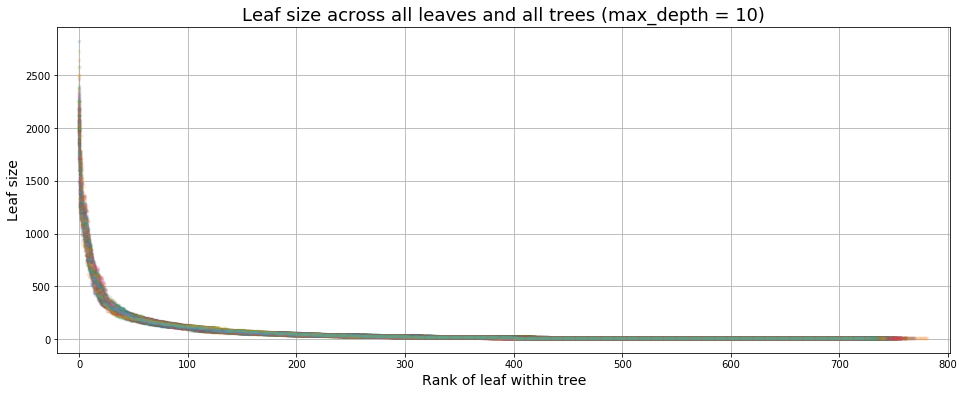

In [19]:
fig, ax = plt.subplots(figsize=FIGSIZE);

logy = False
leaf_sizes_pivot.plot(style=':.', alpha=20/n_estimators, logy=logy, ax=ax);
ax.set_xlabel('Rank of leaf within tree', fontsize=14);
ax.set_ylabel('Leaf size', fontsize=14);
ax.set_title("Leaf size across all leaves and all trees (max_depth = {0})".format(max_depth), fontsize=18);
ax.set_xlim([-20, tree_info['nb of leaves'].max()+20]);
ax.get_legend().remove();
ax.grid();
# ax.scatter(leaf_sizes['rank'], leaf_sizes['leaf size'], alpha=10/n_estimators);

The pattern is remarkably regular.  It shows, unequivocally, that the size of the leaves varies greatly within *every* tree.  Below we confirm quantitatively the following observations:  
- the median leaf size is very stable across the trees provided `max_depth` is not too small (e.g. 10);  
- the standard deviation of the leaf size is not negligible provided `max_depth` is not extremely large (definitely the case with both `max_depth = 5` and `10`).  

We calculate further statistics on leaf size:

In [20]:
leaf_size_median = leaf_sizes.groupby('trial').apply(lambda x: x['leaf size'].median().astype(np.uint16))
leaf_size_mean = leaf_sizes.groupby('trial').apply(lambda x: x['leaf size'].mean())
leaf_size_std = leaf_sizes.groupby('trial').apply(lambda x: x['leaf size'].std())

## Average leaf size

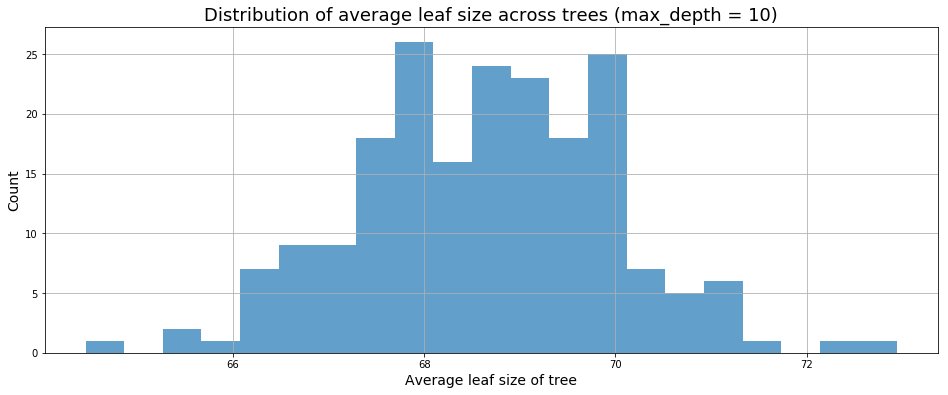

In [21]:
fig, ax = plt.subplots(figsize=FIGSIZE);
bins = 21
leaf_sizes.groupby('trial').apply(lambda x: x['leaf size'].mean()).hist(bins=bins, alpha=ALPHA, ax=ax);
ax.set_title("Distribution of average leaf size across trees (max_depth = {0})".format(max_depth), fontsize=18);
ax.set_xlabel("Average leaf size of tree", fontsize=14);
ax.set_ylabel("Count", fontsize=14);

In case `max_depth = 5` where all leaves of all trees have a depth of `max_depth`, the average leaf size is the same for all trees.

## Spread of leaf size

The plot with all the leaves' size shows the extent to which the leaf size varies within each tree.  Evaluate the spread of leaf size:

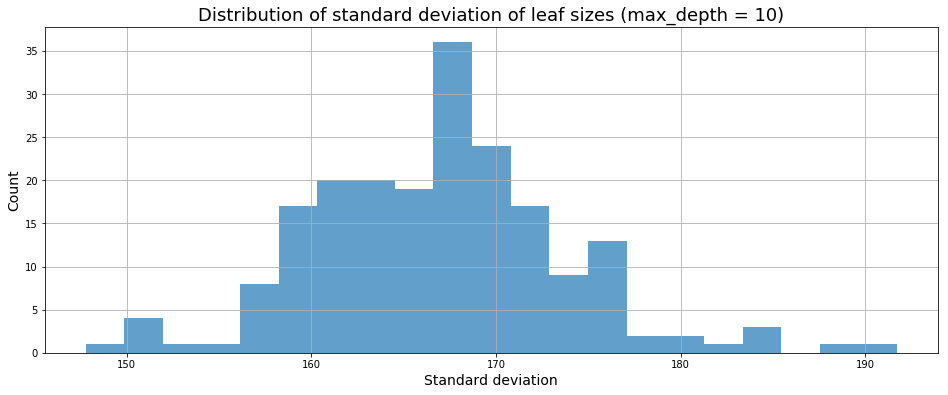

In [22]:
fig, ax = plt.subplots(figsize=FIGSIZE);
bins = 21
leaf_size_std.hist(bins=bins, alpha=ALPHA, ax=ax);
ax.set_title("Distribution of standard deviation of leaf sizes (max_depth = {0})".format(max_depth), fontsize=18);
ax.set_xlabel("Standard deviation", fontsize=14);
ax.set_ylabel("Count", fontsize=14);

Indeed, we see that the spread is quite large, roughly twice the average leaf size itself.  

## Median leaf size


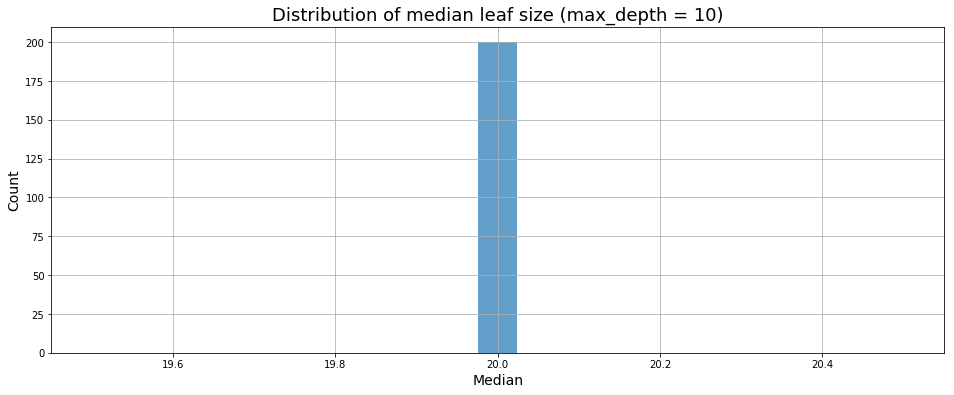

In [23]:
fig, ax = plt.subplots(figsize=FIGSIZE);

# leaf_size_median_counts = leaf_size_median.value_counts().to_frame('count')
# ax.bar(x=leaf_size_median_counts.index, height=leaf_size_median_counts['count'], alpha=ALPHA);

bins = 21
leaf_size_median.hist(bins=bins, alpha=ALPHA, ax=ax)
ax.set_title("Distribution of median leaf size (max_depth = {0})".format(max_depth), fontsize=18);
ax.set_xlabel("Median", fontsize=14);
ax.set_ylabel("Count", fontsize=14);

For `max_depth = 10`, the median is very stable, which is not surprising in view of the graph showing the decay of leaf size across trees.  In contrast, for `max_depth = 5`, the median fluctuates quite a bit.  

# Structure of decision trees with `min_samples_leaf` prescribed


## Create and train decision trees

In [24]:
%time

n_estimators = 400 # 200
min_samples_leaf = 50
max_features = 2 #1 # 3 # 2

rf = RandomForestRegressor(
    n_jobs=-1,
    n_estimators=n_estimators,
    min_samples_leaf=min_samples_leaf,
    max_features=max_features
);
rf.fit(X_train, y_train)
estimators = rf.estimators_

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 7.15 µs


## Global structure properties

Let's collect the **maximum depth**,  **number of leaves**,  and **capacity** in the trees of our list:

In [25]:
tree_info = pd.DataFrame(
    data=[(estimator.tree_.max_depth, dectree_depths(estimator.tree_)['is_leaf'].sum(), estimator.tree_.capacity)
          for estimator in estimators],
    columns=['max depth', 'nb of leaves', 'capacity']
)
tree_info.index.name = 'trial nb'

tree_info.describe()

,max depth,nb of leaves,capacity
count,400.000000,400.000000,400.000000
mean,17.860000,469.927500,938.855000
std,1.028613,5.340745,10.681489
min,15.000000,455.000000,909.000000
25%,17.000000,466.000000,931.000000
50%,18.000000,470.000000,939.000000
75%,18.000000,473.000000,945.000000
max,22.000000,485.000000,969.000000


## Number of leaves

Since we have prescribed the minimum number of samples in a leaf, and recalling the binary structure of the trees, the number of leaves in a tree cannot be more than

In [26]:
math.ceil(raw_data.shape[0] / min_samples_leaf)

1210

Let's plot the number of leaves:

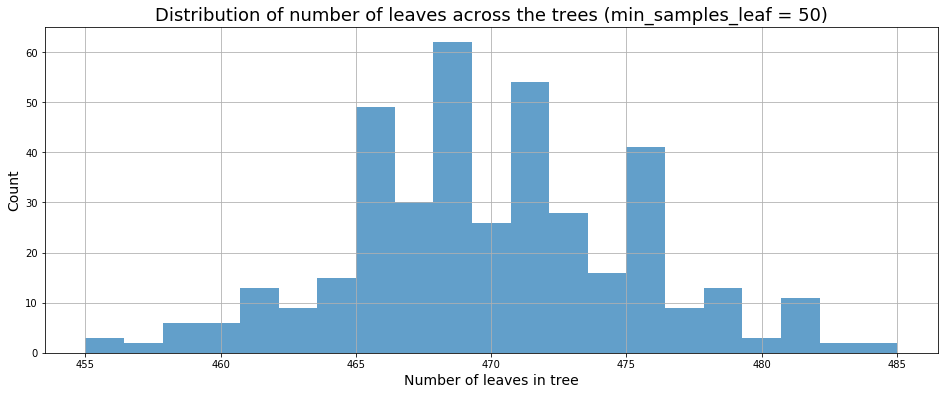

In [27]:
fig, ax = plt.subplots(figsize=FIGSIZE);

bins = 21
tree_info['nb of leaves'].hist(bins=bins, alpha=0.7, ax=ax);
ax.set_title("Distribution of number of leaves across the trees (min_samples_leaf = {0})".format(min_samples_leaf), fontsize=18);
ax.set_xlabel("Number of leaves in tree", fontsize=14);
ax.set_ylabel("Count", fontsize=14);

## Maximum depth
Since we are only prescribing `min_samples_leaf`, the best (i.e. least) upper bound on the maximum depth in a tree is also equal to the maximum number of leaves calculated above:

In [28]:
math.ceil(raw_data.shape[0] / min_samples_leaf)

1210

Indeed, the worst case scenario is a binary tree where every node which is not a leaf splits into one leave (say to its left) and another node which is not a leaf (to its right).  The best case scenario is that of a balanced tree, where all leaves have same depth, in which case it is

In [29]:
math.ceil(np.log2(math.ceil(raw_data.shape[0] / min_samples_leaf)))

11

For our trees, this upper bound is extremely conservative.

In [30]:
max_depth_count = tree_info['max depth'].value_counts().to_frame().reset_index().rename(columns={'index': 'max depth', 'max depth': 'count'}).set_index('max depth')

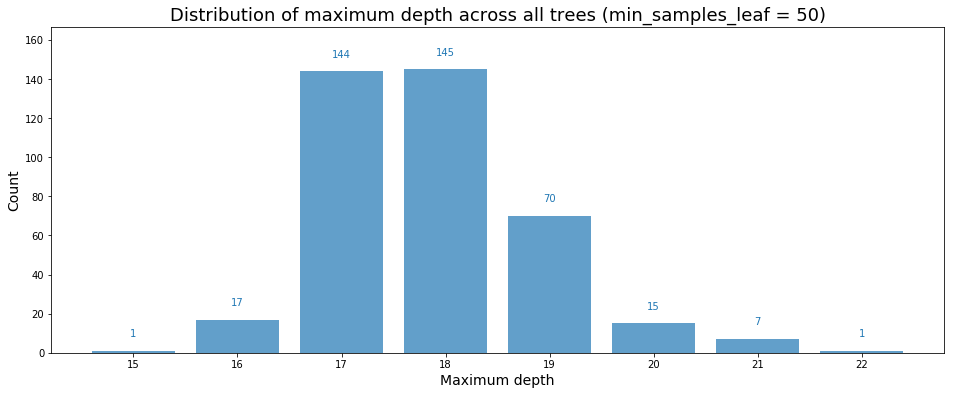

In [31]:
fig, ax = plt.subplots(figsize=FIGSIZE);

ax.bar(x=max_depth_count.index, height=max_depth_count['count'], alpha=ALPHA);
dy = max_depth_count['count'].max()/20
for index, row in max_depth_count.iterrows():
    ax.text(index, row[0] + dy, int(row[0]), horizontalalignment='center', color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
    
ax.set_title("Distribution of maximum depth across all trees (min_samples_leaf = {0})".format(min_samples_leaf), fontsize=18);
ax.set_xlabel("Maximum depth", fontsize=14);
ax.set_ylabel("Count", fontsize=14);
ax.set_ylim([0, max_depth_count['count'].max() + 3*dy]);

## Depth of leaves

We calculate the depths of all leaves and all trees:

In [32]:
depths = pd.concat(
    [dectree_depths(estimator.tree_).assign(**{'trial': i})  for i, estimator in enumerate(estimators)],
    axis=0
).query('is_leaf == True').drop('is_leaf', axis=1)
# depths.info()

In [33]:
depths.head()

,depth,trial
leaf id,,
6,6,0
7,6,0
11,8,0
14,10,0
15,10,0


In [34]:
depth_summary = depths['depth'].value_counts().to_frame()
# depth_summary

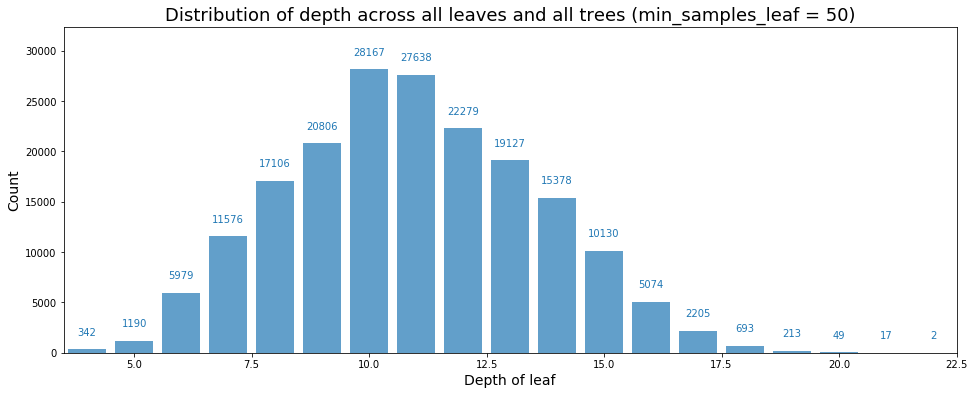

In [35]:
fig, ax = plt.subplots(figsize=FIGSIZE)

ax.bar(x=depth_summary.index, height=depth_summary['depth'], alpha=ALPHA);

ax.set_title("Distribution of depth across all leaves and all trees (min_samples_leaf = {0})".format(min_samples_leaf), fontsize=18)
ax.set_xlabel("Depth of leaf", fontsize=14);
ax.set_ylabel("Count", fontsize=14);

dy = depth_summary['depth'].max()/20


for index, row in depth_summary.iterrows():
    ax.text(index, row[0] + dy, int(row[0]), horizontalalignment='center', color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
# for i, v in list(zip(bins, n)):
#     ax.text(i + 0.5, v + dv, int(v), horizontalalignment='center', color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0])

ax.set_ylim([0, depth_summary['depth'].max() + 3*dy]);
ax.set_xlim([depth_summary.index.min() - 0.5, depth_summary.index.max() + 0.5]);
# ax.set_xticks(range(depth_summary['depth'].min(), depth_summary['depth'].max() + 1))



For emphasis, this plot is an **aggregate** leaf depth.

## Total leaf depth

We have seen that the only bound on maximum depth was useless.  On the other hand, for a balanced tree where all leaves have size `min_samples_leaf`, the total leaf depth is

In [36]:
math.ceil(raw_data.shape[0] / min_samples_leaf) * math.ceil(np.log2(math.ceil(raw_data.shape[0] / min_samples_leaf)))

13310

But note that this is not a lower bound either.  
For our trees, we find:

In [37]:
total_depths = depths.groupby('trial').sum().rename(columns={'depth': 'total depth'})

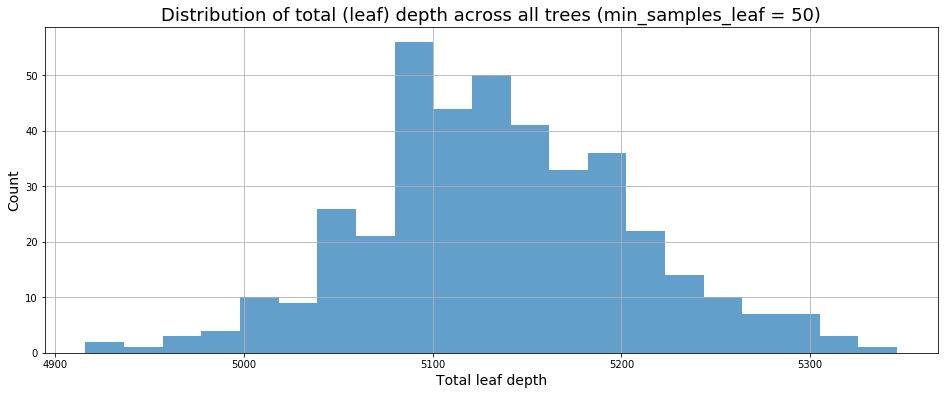

In [38]:
fig, ax = plt.subplots(figsize=FIGSIZE)

bins = 21

total_depths.hist(bins=bins, alpha=ALPHA, ax=ax);
ax.set_title("Distribution of total (leaf) depth across all trees (min_samples_leaf = {0})".format(min_samples_leaf), fontsize=18);
ax.set_xlabel("Total leaf depth", fontsize=14);
ax.set_ylabel("Count", fontsize=14);

## Assining samples to leaves

In [39]:
samples_to_leaves = [pd.DataFrame(data=estimator.apply(X_train), columns=['leaf id']).assign(**{'trial': i}) for i, estimator in enumerate(estimators)]
samples_to_leaves = pd.concat(samples_to_leaves, axis=0)
samples_to_leaves.index.name = 'sample id'
samples_to_leaves.reset_index(inplace=True)
samples_to_leaves = samples_to_leaves[['trial', 'sample id', 'leaf id']]
# samples_to_leaves.sample(5)

## Size of leaves

In [40]:
leaf_sizes = samples_to_leaves.groupby(['trial', 'leaf id'])['sample id'].count().reset_index().rename(index=str, columns={'sample id': 'leaf size'})
leaf_sizes = leaf_sizes.groupby('trial', group_keys=False).apply(lambda x: x.sort_values('leaf size', ascending=False))
leaf_sizes.drop('leaf id', axis=1, inplace=True)
leaf_sizes = leaf_sizes.groupby('trial').apply(lambda x: x.reset_index(drop=True))[['leaf size']].reset_index().rename(index=str, columns={'level_1': 'rank'})

leaf_sizes_pivot = pd.pivot_table(leaf_sizes, index='rank', columns='trial', values='leaf size')

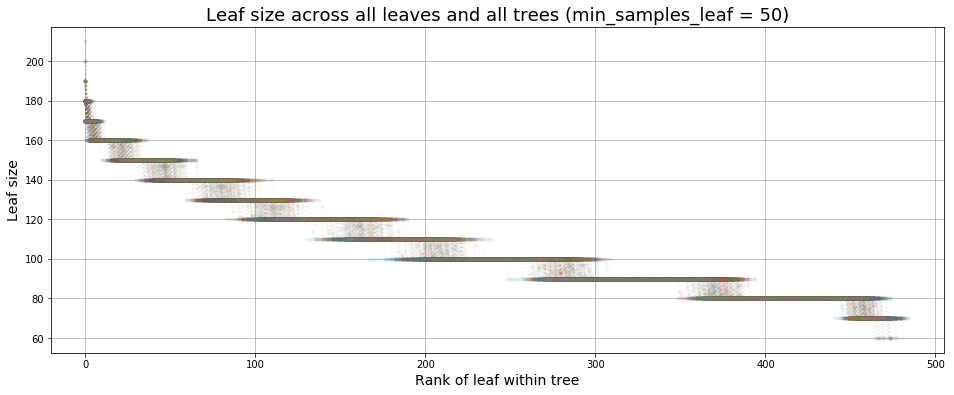

In [41]:
fig, ax = plt.subplots(figsize=FIGSIZE);

logy = False
leaf_sizes_pivot.plot(style=':.', alpha=20/n_estimators, logy=logy, ax=ax);
ax.set_xlabel('Rank of leaf within tree', fontsize=14);
ax.set_ylabel('Leaf size', fontsize=14);
ax.set_title("Leaf size across all leaves and all trees (min_samples_leaf = {0})".format(min_samples_leaf), fontsize=18);
ax.set_xlim([-20, tree_info['nb of leaves'].max()+20]);
ax.get_legend().remove();
ax.grid();

While the leaf size varies quite a lot within each tree, the variation is not as drastic as in the case where `max_depth` is prescribed.

# Conclusion

*To do...*